In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft2, ifft2, fftshift, ifftshift
import cv2
from skimage import io, color, img_as_float, img_as_ubyte, exposure, filters
from scipy.ndimage import convolve

# 1. Geometric Transformations
### 1.1 Image Translation, Scaling (Zooming), Rotation, and Affine Transformations

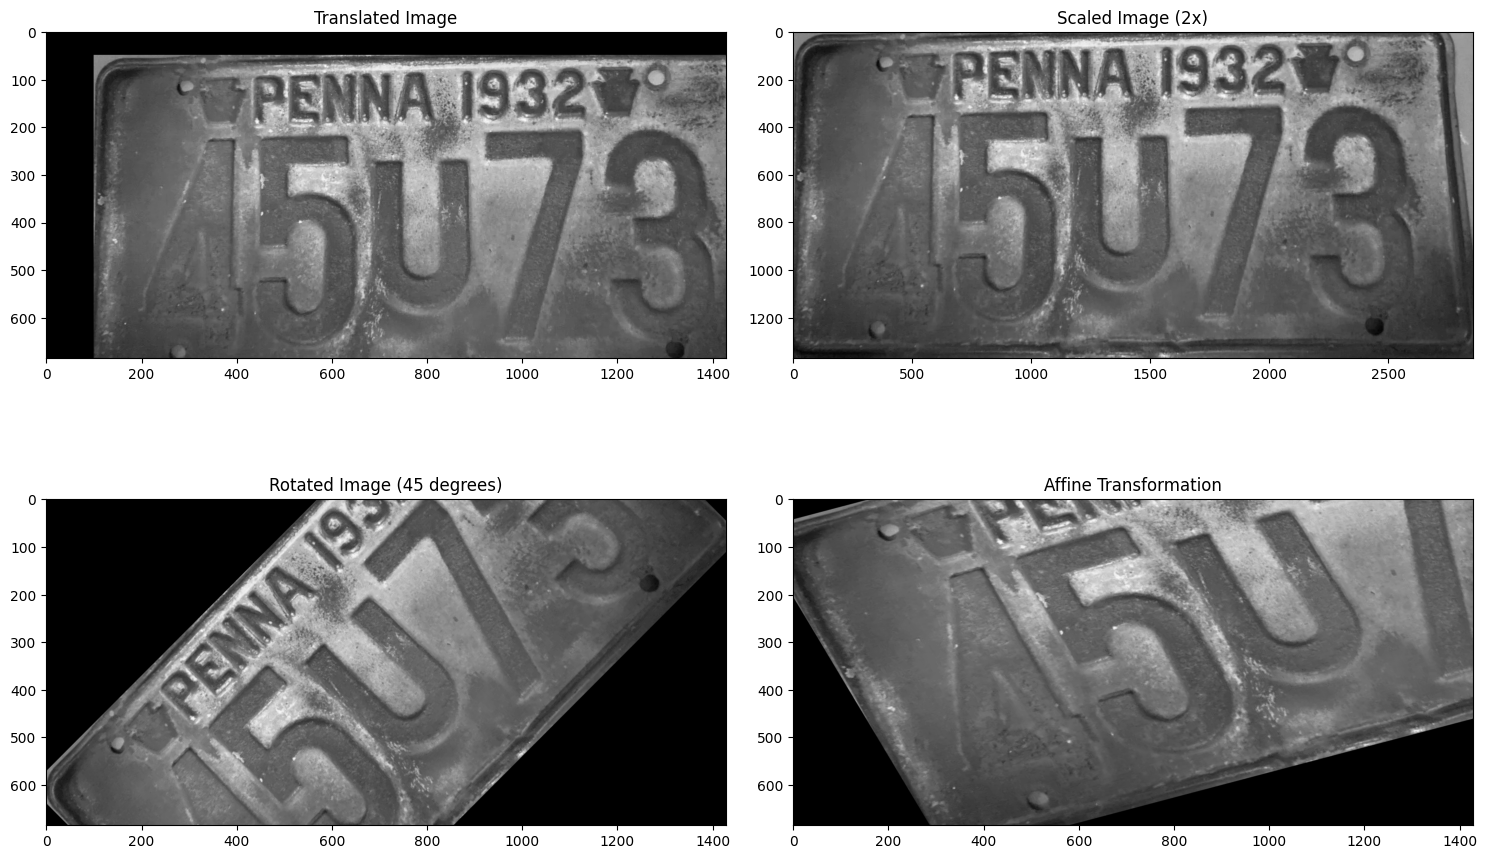

In [2]:
# Load the image and convert to grayscale
img = cv2.imread('s-l1600.jpg')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_gray = color.rgb2gray(img_rgb)
img_gray_8bit = (img_gray * 255).astype(np.uint8)  # Convert to 8-bit

rows, cols = img_gray_8bit.shape

# Translation (move right by 100, down by 50)
M_translation = np.float32([[1, 0, 100], [0, 1, 50]])
translated_img = cv2.warpAffine(img_gray_8bit, M_translation, (cols, rows))

# Scaling (zoom 2x)
scaled_img = cv2.resize(img_gray_8bit, None, fx=2, fy=2, interpolation=cv2.INTER_LINEAR)

# Rotation (45 degrees)
M_rotation = cv2.getRotationMatrix2D((cols/2, rows/2), 45, 1)
rotated_img = cv2.warpAffine(img_gray_8bit, M_rotation, (cols, rows))

# Affine transformation
pts1 = np.float32([[50, 50], [200, 50], [50, 200]])
pts2 = np.float32([[10, 100], [200, 50], [100, 250]])
M_affine = cv2.getAffineTransform(pts1, pts2)
affine_img = cv2.warpAffine(img_gray_8bit, M_affine, (cols, rows))

# Plot the transformations
plt.figure(figsize=(15,10))
plt.subplot(2, 2, 1), plt.imshow(translated_img, cmap='gray'), plt.title('Translated Image')
plt.subplot(2, 2, 2), plt.imshow(scaled_img, cmap='gray'), plt.title('Scaled Image (2x)')
plt.subplot(2, 2, 3), plt.imshow(rotated_img, cmap='gray'), plt.title('Rotated Image (45 degrees)')
plt.subplot(2, 2, 4), plt.imshow(affine_img, cmap='gray'), plt.title('Affine Transformation')
plt.tight_layout()
plt.show()


## 1.2 Forward and Reverse Mapping for Image Warping
### Forward Mapping Example:

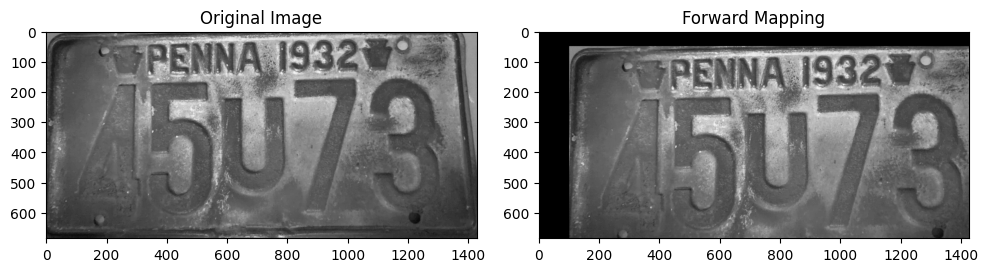

In [3]:
# Define forward mapping function
def forward_mapping(image, M):
    rows, cols = image.shape
    result = np.zeros_like(image)
    for y in range(rows):
        for x in range(cols):
            new_pos = np.dot(M, [x, y, 1])
            new_x, new_y = int(new_pos[0]), int(new_pos[1])
            if 0 <= new_x < cols and 0 <= new_y < rows:
                result[new_y, new_x] = image[y, x]
    return result

# Translation matrix example for forward mapping (move right by 100, down by 50)
M_forward = np.float32([[1, 0, 100], [0, 1, 50], [0, 0, 1]])

# Apply forward mapping
forward_img = forward_mapping(img_gray_8bit, M_forward)

# Plot the original and forward-mapped images side by side
plt.figure(figsize=(10, 5))

# Original Image
plt.subplot(1, 2, 1)
plt.imshow(img_gray_8bit, cmap='gray')
plt.title('Original Image')

# Forward Mapped Image
plt.subplot(1, 2, 2)
plt.imshow(forward_img, cmap='gray')
plt.title('Forward Mapping')

plt.tight_layout()
plt.show()


### Reverse Mapping Example:

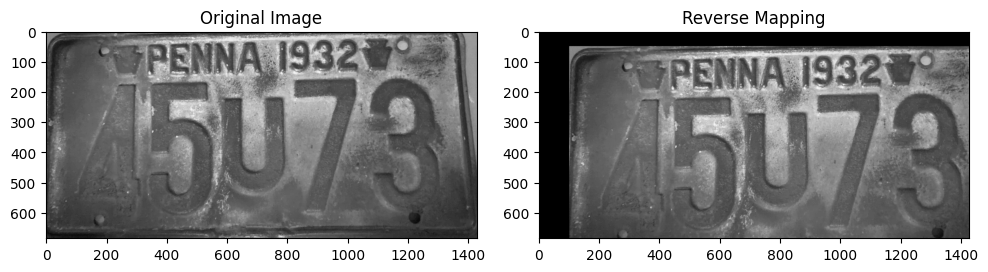

In [4]:
# Define reverse mapping function
def reverse_mapping(image, M_inv):
    rows, cols = image.shape
    result = np.zeros_like(image)
    for y in range(rows):
        for x in range(cols):
            old_pos = np.dot(M_inv, [x, y, 1])
            old_x, old_y = int(old_pos[0]), int(old_pos[1])
            if 0 <= old_x < cols and 0 <= old_y < rows:
                result[y, x] = image[old_y, old_x]
    return result

# Translation matrix example for forward mapping (move right by 100, down by 50)
M_forward = np.float32([[1, 0, 100], [0, 1, 50], [0, 0, 1]])

# Inverse of the translation matrix
M_inv = np.linalg.inv(M_forward)

# Apply reverse mapping
reverse_img = reverse_mapping(img_gray_8bit, M_inv)

# Plot the original and reverse-mapped images side by side
plt.figure(figsize=(10, 5))

# Original Image
plt.subplot(1, 2, 1)
plt.imshow(img_gray_8bit, cmap='gray')
plt.title('Original Image')

# Reverse Mapped Image
plt.subplot(1, 2, 2)
plt.imshow(reverse_img, cmap='gray')
plt.title('Reverse Mapping')

plt.tight_layout()
plt.show()


## 1.3 Radial Distortion Correction

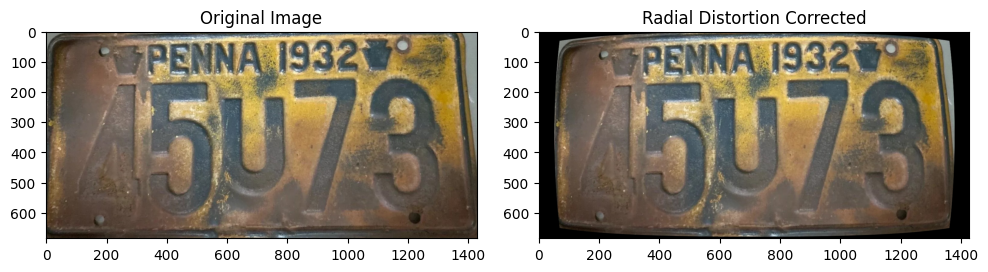

In [5]:
h, w = img.shape[:2]
camera_matrix = np.array([[1000, 0, w//2], [0, 1000, h//2], [0, 0, 1]], dtype="double")

# Adjust distortion coefficients (k1, k2, p1, p2, k3)
dist_coeffs = np.array([0.1, -0.05, 0.0005, 0.0001, 0.5])

# Correct radial distortion
corrected_img = cv2.undistort(img_rgb, camera_matrix, dist_coeffs)

# Display the original and corrected images side by side
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img_rgb)
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(corrected_img)
plt.title('Radial Distortion Corrected')

plt.tight_layout()
plt.show()


# 2. Interpolation Techniques
## 2.1 Nearest-Neighbor Interpolation

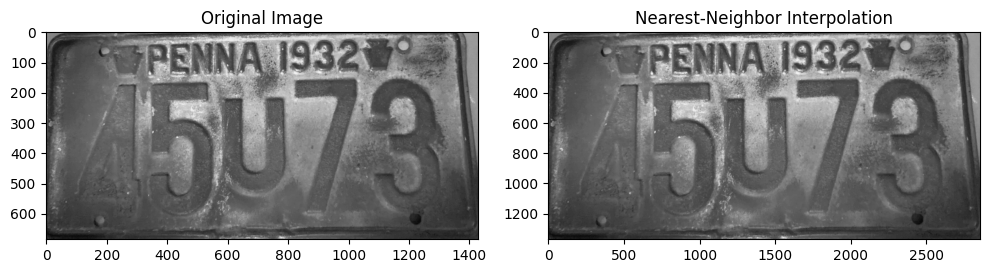

In [6]:
# Nearest-Neighbor Interpolation (resize by 2x)
nearest_neighbor_img = cv2.resize(img_gray_8bit, (cols * 2, rows * 2), interpolation=cv2.INTER_NEAREST)

# Plot the original and nearest-neighbor interpolated images side by side
plt.figure(figsize=(10, 5))

# Original Image
plt.subplot(1, 2, 1)
plt.imshow(img_gray_8bit, cmap='gray')
plt.title('Original Image')

# Nearest-Neighbor Interpolated Image
plt.subplot(1, 2, 2)
plt.imshow(nearest_neighbor_img, cmap='gray')
plt.title('Nearest-Neighbor Interpolation')

plt.tight_layout()
plt.show()

## 2.2 Bilinear Interpolation

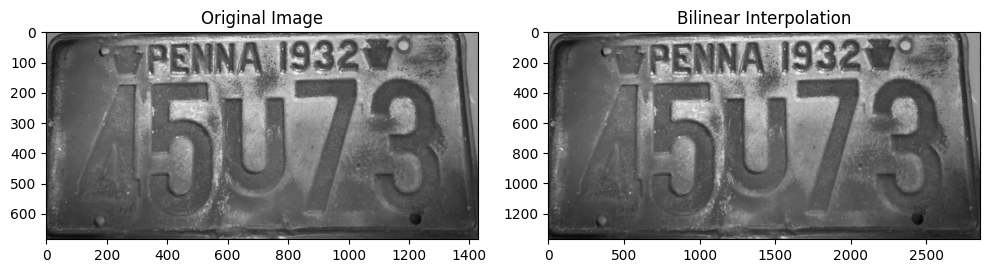

In [7]:
# Bilinear Interpolation (resize by 2x)
bilinear_img = cv2.resize(img_gray_8bit, (cols * 2, rows * 2), interpolation=cv2.INTER_LINEAR)

# Plot the original and bilinear interpolated images side by side
plt.figure(figsize=(10, 5))

# Original Image
plt.subplot(1, 2, 1)
plt.imshow(img_gray_8bit, cmap='gray')
plt.title('Original Image')

# Bilinear Interpolated Image
plt.subplot(1, 2, 2)
plt.imshow(bilinear_img, cmap='gray')
plt.title('Bilinear Interpolation')

plt.tight_layout()
plt.show()

## 2.3 Bicubic Interpolation

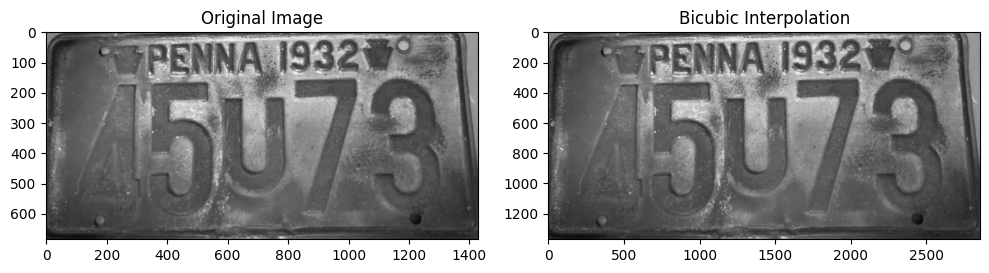

In [8]:
# Bicubic Interpolation (resize by 2x)
bicubic_img = cv2.resize(img_gray_8bit, (cols * 2, rows * 2), interpolation=cv2.INTER_CUBIC)

# Plot the original and bicubic interpolated images side by side
plt.figure(figsize=(10, 5))

# Original Image
plt.subplot(1, 2, 1)
plt.imshow(img_gray_8bit, cmap='gray')
plt.title('Original Image')

# Bicubic Interpolated Image
plt.subplot(1, 2, 2)
plt.imshow(bicubic_img, cmap='gray')
plt.title('Bicubic Interpolation')

plt.tight_layout()
plt.show()

# 3. Image Registration (Optional, Advanced)
## Basic Image Registration Using Feature Matching (ORB):

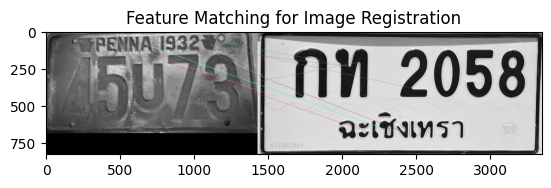

(<matplotlib.image.AxesImage at 0x23868a259d0>,
 Text(0.5, 1.0, 'Feature Matching for Image Registration'),
 None)

In [9]:
# Load two images for registration
img1 = cv2.imread('s-l1600.jpg', 0)  # Grayscale image 1
img2 = cv2.imread('License_plate_003.jpg', 0)  # Grayscale image 2

# Detect ORB keypoints and descriptors
orb = cv2.ORB_create()
kp1, des1 = orb.detectAndCompute(img1, None)
kp2, des2 = orb.detectAndCompute(img2, None)

# Brute-force matcher to match keypoints
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(des1, des2)
matches = sorted(matches, key=lambda x: x.distance)

# Draw the top 10 matches
img_matches = cv2.drawMatches(img1, kp1, img2, kp2, matches[:10], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Display matches
plt.imshow(img_matches), plt.title('Feature Matching for Image Registration'), plt.show()
